## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/testing'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training')]

In [5]:
il = ImageList.from_folder(path, convert_mode='L')

In [7]:
il.items[0]

PosixPath('/home/jupyter/.fastai/data/mnist_png/testing/1/8914.png')

In [8]:
defaults.cmap='binary' # default colormap

In [9]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png

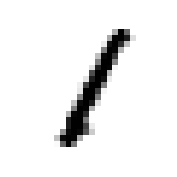

In [11]:
il[0].show()

In [12]:
sd = il.split_by_folder(train='training', valid='testing')

In [13]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

In [14]:
(path/'training').ls()

[PosixPath('/home/jupyter/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/8'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/jupyter/.fastai/data/mnist_png/training/4')]

In [15]:
ll = sd.label_from_folder()

In [16]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,1,1,1,1
Path: /home/jupyter/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
1,1,1,1,1
Path: /home/jupyter/.fastai/data/mnist_png;

Test: None

In [17]:
x,y = ll.train[0]

1 torch.Size([1, 28, 28])


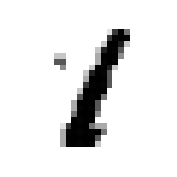

In [19]:
x.show()
print(y,x.shape)

In [20]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [21]:
ll = ll.transform(tfms)

In [22]:
bs = 128

In [23]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [24]:
x,y = data.train_ds[0]

1


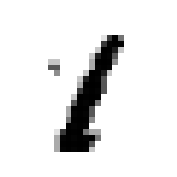

In [25]:
x.show()
print(y)

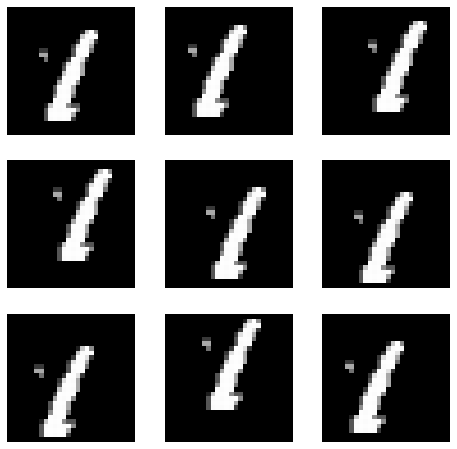

In [26]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [27]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

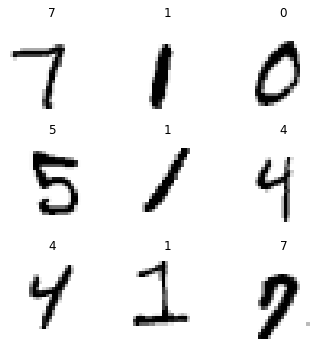

In [28]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [30]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [31]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [32]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [33]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [34]:
xb = xb.cuda()

In [35]:
model(xb).shape

torch.Size([128, 10])

In [36]:
learn.lr_find(end_lr=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


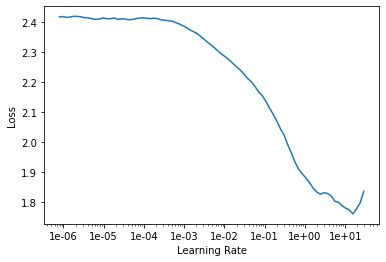

In [37]:
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.229309,0.167410,0.946000,00:06
1,0.133329,0.143795,0.953800,00:06
2,0.076372,0.041245,0.987600,00:05


### Refactor

In [39]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [41]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [42]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [43]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.242778,0.196130,0.941200,00:05
1,0.192527,0.251445,0.925300,00:05
2,0.172489,0.153753,0.948000,00:05
3,0.140757,0.168503,0.945300,00:05
4,0.121968,0.075279,0.977500,00:05
5,0.108636,0.059994,0.980500,00:05
6,0.082768,0.055841,0.982100,00:05
7,0.060782,0.040854,0.986000,00:05
8,0.054058,0.033344,0.988500,00:05
9,0.050563,0.031127,0.989300,00:05


### Resnet-ish

In [44]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [45]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense: bool = False, norm_type: Union[fastai.layers.NormType, NoneType] = <NormType.Batch: 1>, bottle: bool = False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [46]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [48]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [49]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [50]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


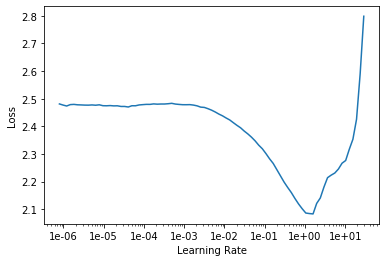

In [51]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.257879,0.263246,0.925000,00:07
1,0.130079,0.132762,0.958500,00:07
2,0.119064,0.083836,0.974000,00:07
3,0.095844,0.080926,0.973900,00:07
4,0.076511,0.086342,0.973300,00:07
5,0.063203,0.053953,0.982100,00:07
6,0.052358,0.039780,0.986700,00:07
7,0.042691,0.031159,0.990400,00:07
8,0.036808,0.030181,0.990900,00:07
9,0.027419,0.021067,0.993500,00:07


In [53]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

## fin